# Multi-View Clustering

The goal of this project is to determine the whether PCA can be used as a means of selecting specific subsets of a dataset to perform clustering upon.

The inspiriation for this project came from stumbling across this paper (https://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf) which explains that PCA is a continuous version of KMeans.

As PCA is a means of identifying latent features within a dataset, I was curious if one could take one of these latent features and identify discrete sets the data tends to cluster along that feature. I decided the most natural way to approach this would be to scale each column by the values of a given principle component and then perform clustering after that. Success will be determined if different principle componenets lead to meaningfully different sets of clusters across the dataset.

## Loading Libraries

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

# Data Preparation

We begin by selecting the specific scores and features we want to focus on.

In [118]:
# Loading the data
nri_df = pd.read_csv("NRI_Table_Counties.csv")

# Selecting only the columns we want to use
selected_columns_old = ['COUNTYFIPS','STATE', 'POPULATION', 'AREA','BUILDVALUE', 'AGRIVALUE', 
                    'RISK_SCORE', 'EAL_SCORE', 'SOVI_SCORE', 'RESL_SCORE', 'AVLN_RISKS',
                    'CFLD_RISKS', 'CWAV_RISKS', 'DRGT_RISKS', 'ERQK_RISKS', 'HAIL_RISKS', 
                    'HWAV_RISKS', 'HRCN_RISKS', 'ISTM_RISKS', 'LNDS_RISKS', 'LTNG_RISKS',
                    'RFLD_RISKS', 'SWND_RISKS', 'TRND_RISKS', 'TSUN_RISKS', 'VLCN_RISKS', 
                    'WFIR_RISKS', 'WNTW_RISKS']

selected_columns_new = ['STCOFIPS', 'POPULATION', 'AREA','BUILDVALUE', 'AGRIVALUE', 
                    'RISK_SCORE', 'EAL_SCORE', 'SOVI_SCORE', 'RESL_SCORE', 
                    'CWAV_RISKS', 'DRGT_RISKS', 'ERQK_RISKS', 'HAIL_RISKS', 
                    'HWAV_RISKS', 'HRCN_RISKS', 'ISTM_RISKS', 'LNDS_RISKS', 'LTNG_RISKS',
                    'RFLD_RISKS', 'SWND_RISKS', 'TRND_RISKS', 
                    'WFIR_RISKS', 'WNTW_RISKS']

nri_df = nri_df[selected_columns_new]

In [119]:
# Filling in missing values with 0
for col in nri_df.columns:
    nri_df[col] = nri_df[col].fillna(0)

# Checking that all values are handled
for col in nri_df.columns:
    print(f"{col}: {sum(nri_df[col].isnull())}")


# Applying log transform to all features except lat and lng
for col in nri_df.columns:
    if col != 'STCOFIPS':
        nri_df[col] = np.log(nri_df[col] + 0.0001)

STCOFIPS: 0
POPULATION: 0
AREA: 0
BUILDVALUE: 0
AGRIVALUE: 0
RISK_SCORE: 0
EAL_SCORE: 0
SOVI_SCORE: 0
RESL_SCORE: 0
CWAV_RISKS: 0
DRGT_RISKS: 0
ERQK_RISKS: 0
HAIL_RISKS: 0
HWAV_RISKS: 0
HRCN_RISKS: 0
ISTM_RISKS: 0
LNDS_RISKS: 0
LTNG_RISKS: 0
RFLD_RISKS: 0
SWND_RISKS: 0
TRND_RISKS: 0
WFIR_RISKS: 0
WNTW_RISKS: 0


In [122]:
# Loading Location Data
location_df = pd.read_csv("uscounties.csv")

# Converting features to numeric
location_df["county_fips"] = pd.to_numeric(location_df["county_fips"])
location_df["lat"] = pd.to_numeric(location_df["lat"])
location_df["lng"] = pd.to_numeric(location_df["lng"])

# Selecting only the columns we want to use
location_df = location_df[["county_fips", "lat", "lng"]]

# Combining the data joining on the county fips
counties_df = nri_df.set_index("STCOFIPS").join(location_df.set_index("county_fips"))   

# Removing NaN values
counties_df = counties_df.dropna()

nri_df = counties_df.drop(['lng', 'lat'], axis=1)

# Clustering without PCA

## Is the data clusterable?

We first invistage the degree to which our data can be meaningfully clustered by examing the distribution of distances between points. If our data is broken up into clusters, then we ought to see multiple peaks in the histogram.

In [ ]:
from scipy.spatial import distance_matrix

dist_mat = distance_matrix(nri_df, nri_df, p=2)
dist_mat = np.triu(dist_mat).flatten()
dist_mat = dist_mat[np.nonzero(dist_mat)]

plt.hist(dist_mat, bins=200)
plt.plot()

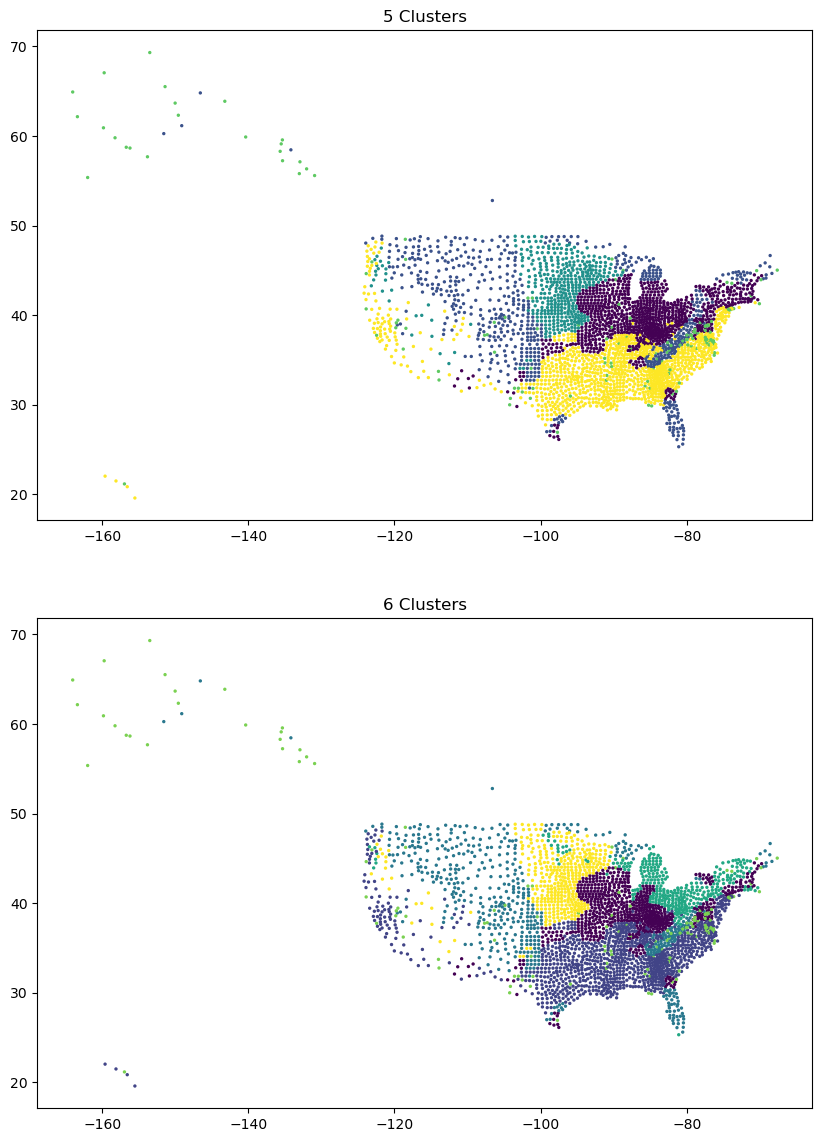

In [147]:
# KMeans Clustering

upper_bound = 7
lower_bound = 5

fig, ax = plt.subplots(upper_bound-lower_bound, ncols=1, figsize=(10, 7* (upper_bound-lower_bound)))
for num_clusters in range(lower_bound,upper_bound):
    idx = num_clusters - lower_bound
    kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(nri_df)
    ax[idx].scatter(counties_df['lng'], counties_df['lat'], c=kmeans.labels_, s=2)
    ax[idx].set_title(f"{num_clusters} Clusters")
plt.show()
    

In [148]:
kmeans = KMeans(n_clusters=6, random_state=1).fit(nri_df)

cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=counties_df.columns[:-2])

cluster_centers_df

,POPULATION,AREA,BUILDVALUE,AGRIVALUE,RISK_SCORE,EAL_SCORE,SOVI_SCORE,RESL_SCORE,CWAV_RISKS,DRGT_RISKS,...,HWAV_RISKS,HRCN_RISKS,ISTM_RISKS,LNDS_RISKS,LTNG_RISKS,RFLD_RISKS,SWND_RISKS,TRND_RISKS,WFIR_RISKS,WNTW_RISKS
0,10.527509,6.217277,22.115393,17.911889,2.177076,2.514037,3.533368,4.014731,2.876673,1.926638,...,2.070162,1.213485,2.185185,2.211022,2.347948,2.076461,2.562471,2.696573,0.437446,2.508423
1,10.557163,6.416103,22.034043,17.540747,2.406669,2.625712,3.616915,3.980122,-9.210340,1.922953,...,0.510353,0.768055,1.747694,2.167805,2.433437,2.143386,2.391540,2.776862,1.299193,2.213198
2,9.796323,7.093235,21.403544,17.595476,2.099563,2.335985,3.600541,3.974802,2.011735,1.712555,...,-9.198027,-5.631248,0.916150,2.056984,2.081135,1.295451,1.981467,2.015418,1.779935,1.396039
3,10.859171,6.325441,22.533187,17.593529,1.996818,2.311013,3.571363,4.029874,2.739775,-9.210340,...,-0.708083,0.284527,2.230010,2.358871,2.395868,1.914070,2.329271,2.397901,0.187276,2.438903
4,9.693344,5.727248,21.415869,-9.210340,1.886958,2.023622,3.684089,3.960902,-4.598484,-9.210340,...,-2.947958,-2.105813,1.107647,0.191814,0.309481,0.327040,0.614733,1.606574,-1.777939,1.101843
5,9.419331,6.708333,21.128088,18.730132,2.131404,2.415334,3.614372,4.042672,2.897451,2.174577,...,1.791850,-9.210340,2.163280,1.946553,1.965434,1.326558,2.466419,2.457998,1.357143,2.737632


The problem with these means is that they are difficult to interpret and seem to be combining a bunch of different factors. It would be more ideal if the cluster only had a few key attributes.

## Performing PCA on the Dataset

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

pca= PCA()

pca_df = pca.fit_transform(nri_df)

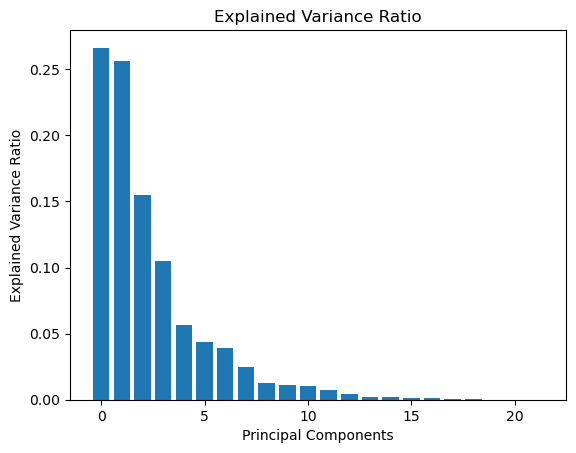

In [129]:
# create a bar plot of the explained variance ratios
fig, ax = plt.subplots()
ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio')
plt.show()

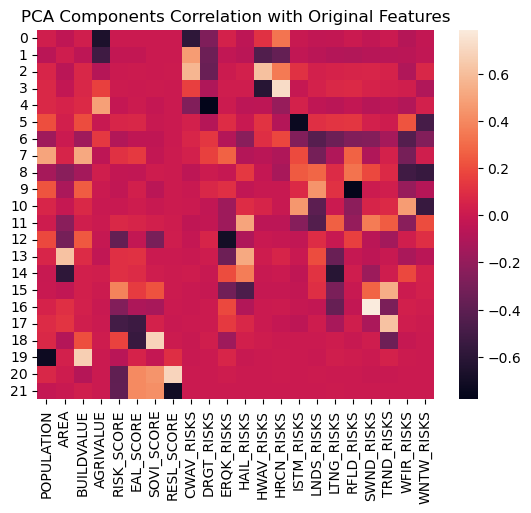

In [131]:
pca_df = pd.DataFrame(pca.components_, columns=nri_df.columns)
sns.heatmap(pca_df)
plt.title('PCA Components Correlation with Original Features')
plt.show()

Importantly, we see that the data is explained by a few key principle componenets AND that these componenets are only associated with a few key features. We want to see if we can exploit that fact.

In [132]:
pca_df = pd.DataFrame(pca_df)
pca_df.columns = nri_df.columns

AGRIVALUE    -0.660019
CWAV_RISKS   -0.589844
HRCN_RISKS    0.331864
Name: 0, dtype: float64

In [168]:
def imp_features(pca_i, n_features = 3):
    return pca_i[pca_i.abs().nlargest(n_features).index]


for i in range(2,10):
    print(f"{i}: \n{imp_features(pca_df.iloc[i],5)}\n")

2: 
HWAV_RISKS    0.611645
CWAV_RISKS    0.567780
DRGT_RISKS   -0.354805
HRCN_RISKS    0.345213
ISTM_RISKS    0.108134
Name: 2, dtype: float64

3: 
HRCN_RISKS    0.720044
HWAV_RISKS   -0.616273
AGRIVALUE     0.163613
CWAV_RISKS    0.156891
DRGT_RISKS   -0.105297
Name: 3, dtype: float64

4: 
DRGT_RISKS   -0.780914
AGRIVALUE     0.485041
CWAV_RISKS   -0.267226
HRCN_RISKS   -0.189847
WFIR_RISKS   -0.094062
Name: 4, dtype: float64

5: 
ISTM_RISKS   -0.732577
WNTW_RISKS   -0.490172
WFIR_RISKS    0.225320
POPULATION    0.204228
BUILDVALUE    0.203057
Name: 5, dtype: float64

6: 
WFIR_RISKS   -0.435536
LNDS_RISKS   -0.427081
LTNG_RISKS   -0.346467
RFLD_RISKS   -0.273047
ISTM_RISKS   -0.264105
Name: 6, dtype: float64

7: 
BUILDVALUE    0.513784
POPULATION    0.501526
LNDS_RISKS   -0.313460
WFIR_RISKS   -0.307298
ERQK_RISKS    0.266683
Name: 7, dtype: float64

8: 
WNTW_RISKS   -0.552193
WFIR_RISKS   -0.515198
RFLD_RISKS    0.326128
LNDS_RISKS    0.282197
ISTM_RISKS    0.244478
Name: 8, dtype: f

[]

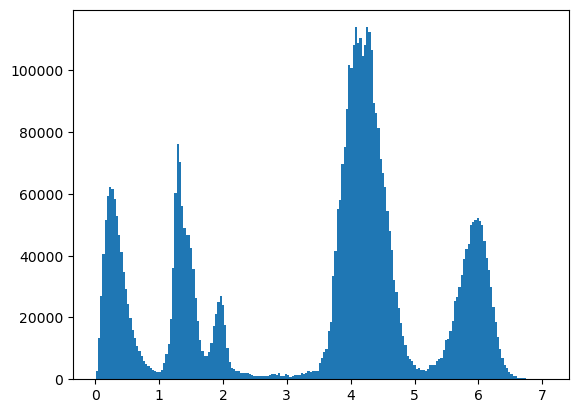

In [149]:
pca_0_scaled_df = pd.DataFrame(nri_df).apply(lambda x: x * pca_df.iloc[2][x.name]**2)

pca_0_scaled_df

dist_mat = distance_matrix(pca_0_scaled_df, pca_0_scaled_df, p=2)
dist_mat = np.triu(dist_mat).flatten()
dist_mat = dist_mat[np.nonzero(dist_mat)]

plt.hist(dist_mat, bins=200)
plt.plot()


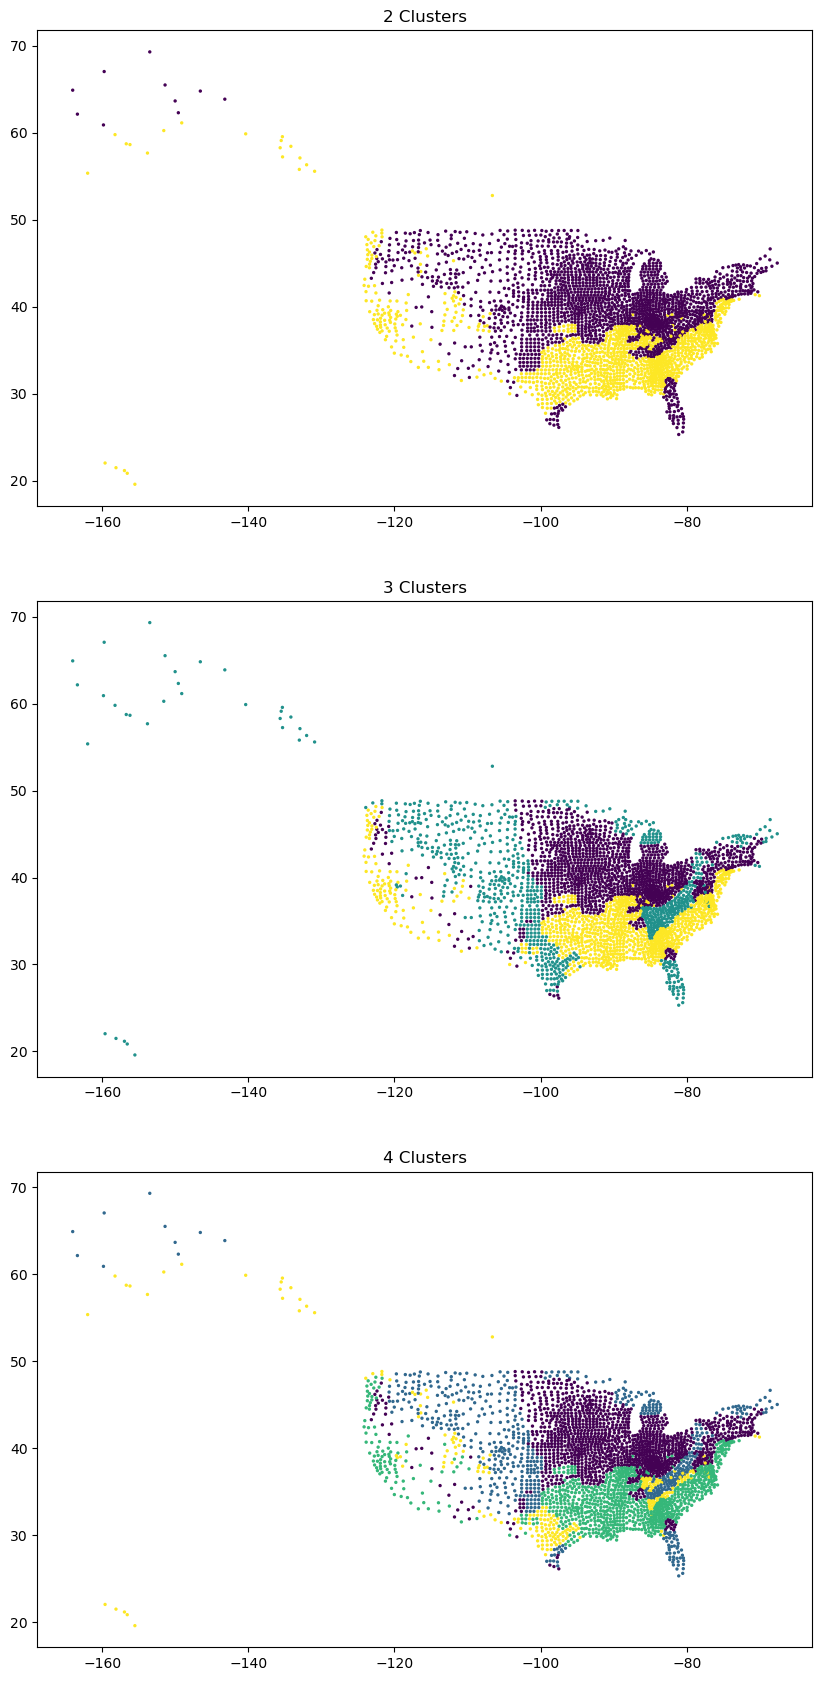

In [150]:
upper_bound = 5
lower_bound = 2

fig, ax = plt.subplots(upper_bound-lower_bound, ncols=1, figsize=(10, 7* (upper_bound-lower_bound)))
for num_clusters in range(lower_bound,upper_bound):
    idx = num_clusters - lower_bound
    kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(pca_0_scaled_df)
    ax[idx].scatter(counties_df['lng'], counties_df['lat'], c=kmeans.labels_, s=2)
    ax[idx].set_title(f"{num_clusters} Clusters")
plt.show()